# <font color=green>deepBreaks Applications</font>
## Predicting the Phenotype of an Opsin From its Amino Acid Sequence...
## This Version of our pipeline uses deepBreaks v. 1.1.0! 
[Env name == deepBreaks]
</p>

# <font color=red>Step 0: mySQL DB Setup -</font> Script 0
## *The following text is a script written in mySQL format. You can copy and paste this directly into a mySQL text file or query window within mySQL workbench.*
```
DROP DATABASE vizphiz;
CREATE DATABASE vizphiz;
USE vizphiz;

CREATE TABLE lamdamax
(
id int unsigned not null primary key,
genus varchar(50),
species varchar(50),
celltype varchar(50),
cellsubtype varchar(50),
lamdamax decimal(9,5),
error decimal(9,5),
chromophore varchar(50),
method varchar(50),
stage varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE heterologous
(
hetid int unsigned not null primary key,
genus  varchar(50),
species varchar(50),
accession varchar(500),
mutations varchar(500),
lamdamax decimal(9,5),
error decimal(9,5),
cellculture varchar(50),
purification varchar(50),
spectrum varchar(50),
sourcetype varchar(50),
refid int,
notes varchar(1000)
);

CREATE TABLE links
(
linkid int unsigned not null primary key,
accession varchar(500),
maxid int,
refid int,
evidence varchar(1000)
);

CREATE TABLE search
(
searchid int unsigned not null primary key,
researcher varchar(50),
month int,
year int,
engine varchar(500),
keywords varchar(500)
);

CREATE TABLE opsins
(
opsinid int unsigned not null primary key,
genefamily varchar(50),
genenames varchar(50),
genus varchar(50),
species varchar(50),
db varchar(50),
accession varchar(500),
dna varchar(10000),
aa varchar(3333),
refid int
);

CREATE TABLE refs
(
refid int,
doilink varchar(100),
searchid int
);
``` 

In [1]:
#All neccessary packages to import for data process steps.
import mysql
#install mysql-connector-python // NOT mysql-connector
import mysql.connector
import argparse
import re
import pandas as pd
import jenkspy 
from matplotlib import pyplot as plt

# <font color=red>STEP 0: Data Base Setup -</font> Script 1 - Import heterologous.tsv into mySQL


In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('heterologous.tsv', 'r', encoding="utf8")
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")
    print(columns)
    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9], columns[10], columns[12])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")

['1', 'Tachyglossus', 'aculeatus', 'JX103830', '', '497.9', '1.1', 'HEK293T', '1D4 antibody', '', '', '', '116', 'none\n']
INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
('1', 'Tachyglossus', 'aculeatus', 'JX103830', '', '497.9', '1.1', 'HEK293T', '1D4 antibody', '', '', '116')
1 record inserted.
['2', 'Tachyglossus', 'aculeatus', 'JX103830_N83D', 'N83D', '503.8', '1.5', 'HEK293T', '1D4 antibody', '', '', '', '116', '\n']
INSERT INTO opsins.heterologous (hetid, genus, species, accession, mutations, lamdamax, error, cellculture, purification, spectrum, sourcetype, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
('2', 'Tachyglossus', 'aculeatus', 'JX103830_N83D', 'N83D', '503.8', '1.5', 'HEK293T', '1D4 antibody', '', '', '116')
1 record inserted.
['3', 'Tachyglossus', 'aculeatus', 'JX103830_T158A', 'T158A', '498', '

# <font color=red>STEP 0: Data Base Setup -</font> Script 2 - Import opsindb.tsv into mySQL

In [3]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database= "vizphiz",
  password= "Geass5566!!"
)

#read file for data
file1 = open('opsindb.tsv', 'r')
Lines = file1.readlines()

count=0
for line in Lines:
    columns = line.split("\t")

    mycursor = mydb.cursor()

    sql = "INSERT INTO opsins.opsins (opsinid, genefamily, genenames, genus, species, db, accession, dna, aa, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"
    val = (columns[0], columns[1], columns[2], columns[3], columns[4], columns[5], columns[6], columns[7], columns[8], columns[9])
    print(sql)
    print(val)

    mycursor.execute(sql, val)

    mydb.commit()

    print(mycursor.rowcount, "record inserted.")


INSERT INTO opsins.opsins (opsinid, genefamily, genenames, genus, species, db, accession, dna, aa, refid) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
('1', 'LWS', '', 'Acanthopagrus', 'butcheri', 'NCBI', 'DQ354578.1', 'GGACCCAATTACCACATTGCTCCACGATGGGTTTACAACCTTTCCACATGCTGGATGATTATTGTAGTCATCCTATCAGTCTTCACCAACGGTCTCGTGTTGGTGGCCACGGCAAAGTTCAAGAAACTCCGACACCCTCTGAACTGGATCTTAGTCAATCTCGCAATTGCTGATCTTGGAGAAACAGTTTTTGCCAGCACTATCAGTGTATGCAACCAGTATTTTGGTTACTTCATTCTCGGACACCCGATGTGCATCTTTGAGGGCTACACTGTCTCAGTTTGCGGAATTACTGCTCTCTGGTCCCTGACGATCATCTCCTGGGAGAGGTGGATAGTTGTGTGCAAACCTTTTGGAAACATCAAATTTGATGAAAAATGGGCCATAAGTGGAATAGTGTTCTCCTGGGTCTGGTCAGCAGTGTGGTGTGCTCCCCCCATCTTTGGATGGAGCAGGTACTGGCCTCATGGTCTGAAGACTTCCTGTGGCCCTGATGTATTCAGTGGAAGCGAAGACCCTGGCGTTCAGTCCTACATGGTTGTTCTTATGATCACATGTTGCTTGATTCCTCTGGCTATCATCATCTTATGCTATCTCGCAGTCTGGCTGGCCATCCGTGCAGTTGCCATGCAGCAGAAAGAGTCAGAGTCGACTCAGAAGGCCGAGAGAGAAGTATCCAGGATGGTTGTCGTCATGATCTTTGCATATTGCTTTTGTTGGGGTCCTTACACGTTTTTTGCCTGCTTTGCTGCGGCTAACCCGGGATATGCGTTCCAT

# <font color=red>STEP 1: Extract Data From Vizphiz</font>
### Output = 5 different 'versions' // 'splits' of the data. 
### !Take outputs and run through MAFFT before moving on to STEP2!
### Suggested parameters for 'mafft' alignment are...
1. Fasta Format (Input Order)

2. Strategy = FFT-NS-2 // G-INS-1

In [2]:
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
rod = re.compile('Rh[0-2]|exoRh')
d = re.compile("^NM_001014890.2$|^NM_001014890$")
iec = re.compile("Limenitis|Papilio")



mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

props = ["LambdaMax"]
wds_max = []
wds_ni_max = []
rod_max = []

for x in myresult:
  
  wds_max.append(float(x[4]))

  if (inv.match(x[2]) or iec.match(x[0])):
    pass
  else:  
    wds_ni_max.append(float(x[4]))

  if rod.match(x[2]):
    if (inv.match(x[2]) or iec.match(x[0])):
       pass
    else: 
      rod_max.append(float(x[4]))


wds_hist_df = pd.DataFrame(columns=props, data=wds_max)
wds_ni_hist_df = pd.DataFrame(columns=props, data=wds_ni_max)
rod_hist_df = pd.DataFrame(columns=props, data=rod_max)
hist_list = [wds_hist_df, wds_ni_hist_df, rod_hist_df]

print(hist_list[0])

     LambdaMax
0        502.0
1        502.0
2        481.0
3        494.0
4        494.0
..         ...
856      444.0
857      449.0
858      448.0
859      450.0
860      453.0

[861 rows x 1 columns]


[  0. 396. 467. 496. 511. 611.]


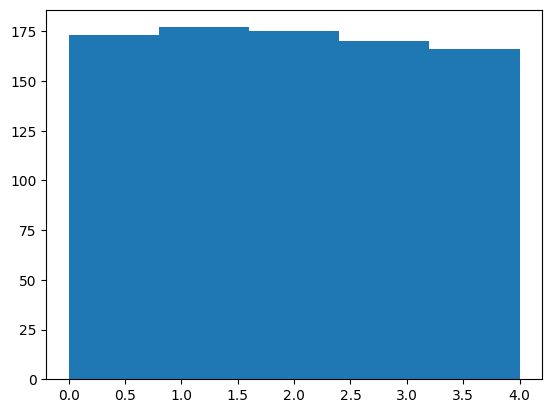

[  0. 360. 396. 433. 467. 488. 496. 501. 511. 536. 611.]


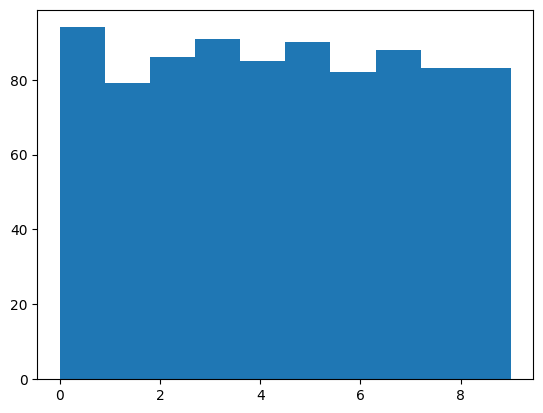

[  0.         359.         363.         396.         420.
 441.66666667 467.         485.         491.         496.
 500.         503.         511.         526.33333333 548.66666667
 611.        ]


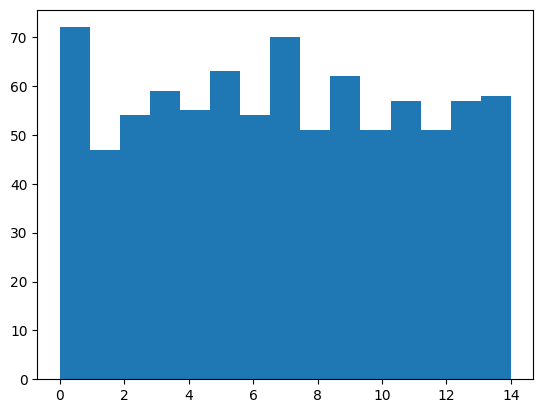

[array([  0., 396., 467., 496., 511., 611.]), array([  0., 360., 396., 433., 467., 488., 496., 501., 511., 536., 611.]), array([  0.        , 359.        , 363.        , 396.        ,
       420.        , 441.66666667, 467.        , 485.        ,
       491.        , 496.        , 500.        , 503.        ,
       511.        , 526.33333333, 548.66666667, 611.        ])]
[  0. 385. 460. 492. 503. 578.]


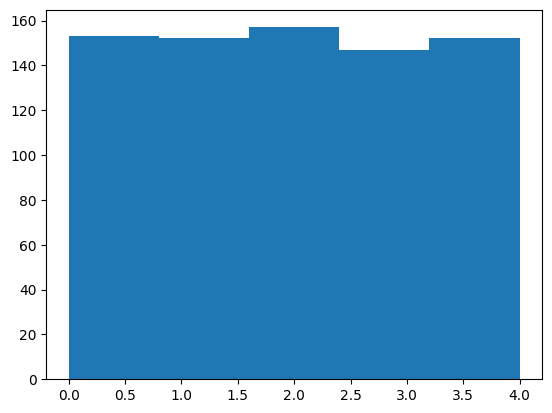

[  0. 360. 385. 421. 460. 486. 492. 499. 503. 520. 578.]


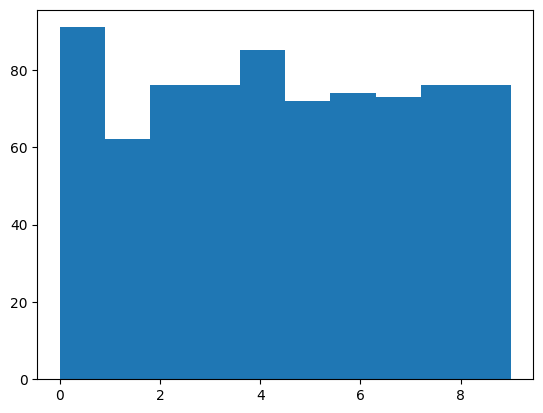

[  0.         359.         361.         385.         416.
 438.         460.         482.         488.         492.
 497.         500.33333333 503.         513.66666667 533.
 578.        ]


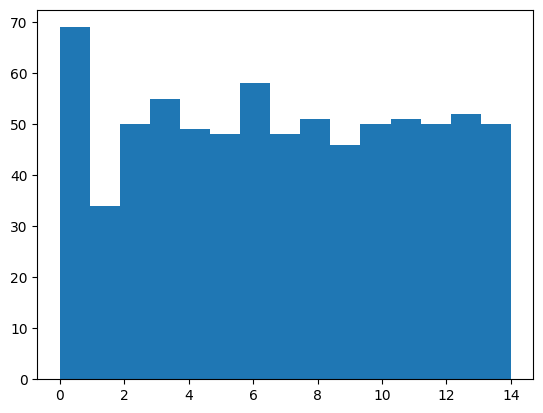

[array([  0., 385., 460., 492., 503., 578.]), array([  0., 360., 385., 421., 460., 486., 492., 499., 503., 520., 578.]), array([  0.        , 359.        , 361.        , 385.        ,
       416.        , 438.        , 460.        , 482.        ,
       488.        , 492.        , 497.        , 500.33333333,
       503.        , 513.66666667, 533.        , 578.        ])]
[  0. 486. 492. 499. 503. 554.]


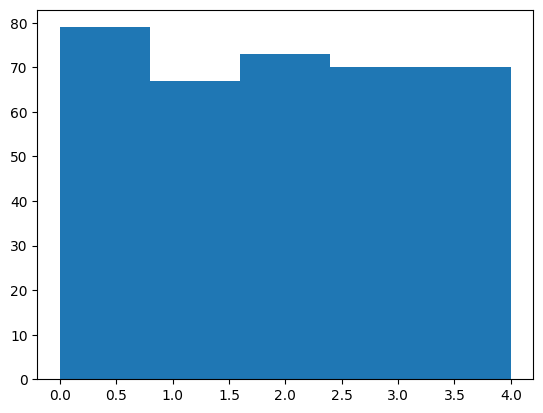

[  0.  475.6 486.  489.  492.  496.  499.  501.  503.  510.  554. ]


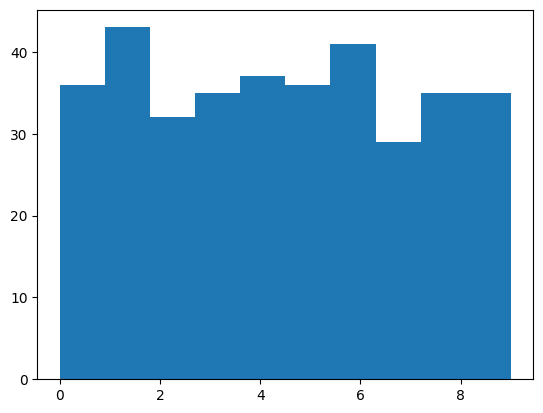

[  0.         467.         482.         486.         488.
 490.33333333 492.         495.         497.46666667 499.
 500.         502.         503.         508.         514.
 554.        ]


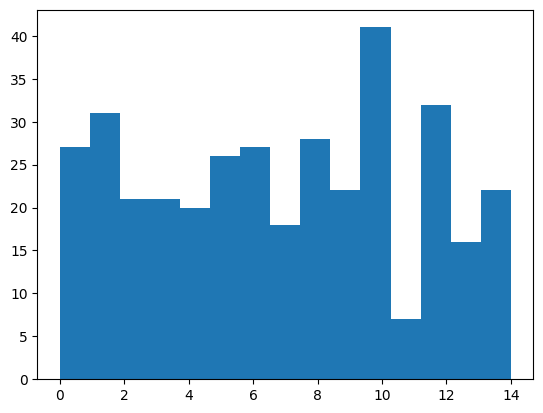

[array([  0., 486., 492., 499., 503., 554.]), array([  0. , 475.6, 486. , 489. , 492. , 496. , 499. , 501. , 503. ,
       510. , 554. ]), array([  0.        , 467.        , 482.        , 486.        ,
       488.        , 490.33333333, 492.        , 495.        ,
       497.46666667, 499.        , 500.        , 502.        ,
       503.        , 508.        , 514.        , 554.        ])]


In [3]:
x = 0
wds_class_list = []
wds_ni_class_list = []
rod_class_list = []

for hist_df in hist_list:
    five = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins=True)
    fiv_list = five[1]
    print(five[1])
    hist_df['bin_qcut5'] = pd.qcut(hist_df['LambdaMax'], q=5, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut5'], bins=5)
    plt.show()

    ten = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins=True)
    ten_list = ten[1]
    print(ten[1])
    hist_df['bin_qcut10'] = pd.qcut(hist_df['LambdaMax'], q=10, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut10'], bins=10)
    plt.show()

    fifteen = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins=True)
    fif_list = fifteen[1]
    print(fifteen[1])
    hist_df['bin_qcut15'] = pd.qcut(hist_df['LambdaMax'], q=15, precision=1, labels=False, retbins = False)
    plt.hist(hist_df['bin_qcut15'], bins=15)
    plt.show()

    if x == 0:
        wds_class_list = [fiv_list, ten_list, fif_list]
        print(wds_class_list)
    elif x == 1:
        wds_ni_class_list = [fiv_list, ten_list, fif_list]
        print(wds_ni_class_list)
    else:
        rod_class_list = [fiv_list, ten_list, fif_list]
        print(rod_class_list)

    x+=1

In [5]:
#Allows for automatic multifacet class assignment during datasplitting
def class_assignment(lmax, class_bounds):
  #lmax = x[4]
  #class_bounds = class_list[splits]
  opclass = 0
  while opclass < len(class_bounds)-1:
    if (round(lmax) > int(class_bounds[opclass]) and round(lmax) <= int(class_bounds[opclass+1])):
        return(opclass)
      
    else:
      opclass += 1

In [6]:
#STEP 1: Extract Data From Vizphiz``

#3 different 'version' // 'splits' of the raw sequence data 
wd_output = 'wds.txt'
wd_ni_output = 'wds_ni.txt'
rod_output = 'rod.txt'

#Regular Metadata Files
wds_metadata = 'wds_meta.tsv'
wd_ni_metadata = 'wds_ni_meta.tsv'
rh_metadata = 'rod_meta.tsv'

#Classifer Specific Metadata Files
class_ni_metadata = ['class_ni_meta_5.tsv','class_ni_meta_10.tsv','class_ni_meta_15.tsv']
class_metadata = ['class_meta_5.tsv','class_meta_10.tsv','class_meta_15.tsv']
class_rod_metadata = ['class_rod_meta_5.tsv','class_rod_meta_10.tsv','class_rod_meta_15.tsv']

invert_counter = 'invert_data.tsv'
#class_ranges = 'classifier_ranges.tsv'
m = 0
s = 0
l = 0
r = 0
c = 0
d = re.compile("^NM_001014890.2$|^NM_001014890%")
iec = re.compile("Limenitis|Papilio")
inv = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
acc_list = []
duped = 0

mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  database="vizphiz",
  password="Geass5566!!"
) 
mycursor = mydb.cursor()

sql = "select DISTINCT o.genus,o.species,o.genefamily,o.accession,h.lamdamax, o.aa from opsins.opsins o, opsins.heterologous h WHERE (o.accession = h.accession AND o.refid = h.refid); "
mycursor.execute(sql)
myresult = mycursor.fetchall()

class_bounds = ten_list

for x in myresult:       

  #Keep all accessions in a list -- don't print 
  if (x[3] in acc_list):
    #print ("\n\n\n****Accession Exists" + x[2] + "\n\n" )
    duped=1
  #First 2 of if statements ignore ancestral (pigment named) or mutated genes
  if (duped==1) :
    duped=0
  #do not print if contains the word "pigment" which is an ancestral sequence

  else :
#REG-DATA SECTION    
       with open(wd_output, 'a') as f:
          if m == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:
            m += 1 
            #This makes the fasta format file
            seq = ">S" + str(m)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)
 
       with open(wd_ni_output, 'a') as f:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")

          c += 1 
          #This makes the fasta format file
          seq = ">S" + str(c)
          f.write(seq)
          seq2 = str('\n' + x[5] + '\n')
          f.write(seq2)

       with open(rod_output, 'a') as f:

        p = re.compile('Rh[0-2]|exoRh')
        if p.match(x[2]):
          if r == 0:
            f.write(">Bovine\nMNGTEGPNFYVPFSNKTGVVRSPFEAPQYYLAEPWQFSMLAAYMFLLIMLGFPINFLTLYVTVQHKKLRTPLNYILLNLAVADLFMVFGGFTTTLYTSLHGYFVFGPTGCNLEGFFATLGGEIALWSLVVLAIERYVVVCKPMSNFRFGENHAIMGVAFTWVMALACAAPPLVGWSRYIPEGMQCSCGIDYYTPHEETNNESFVIYMFVVHFIIPLIVIFFCYGQLVFTVKEAAAQQQESATTQKAEKEVTRMVIIMVIAFLICWLPYAGVAFYIFTHQGSDFGPIFMTIPAFFAKTSAVYNPVIYIMMNKQFRNCMVTTLCCGKNPLGDDEASTTVSKTETSQVAPA\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            r+=1
            #This makes the fasta format file
            seq = ">S" + str(r)
            f.write(seq)
            seq2 = str('\n' + x[5] + '\n')
            f.write(seq2)

#CLASS METADATA SECTION          
       for splits in range(len(class_metadata)): 
        with open(class_metadata[splits], 'a') as h:
            #This makes the metadata formatted for a classification model. 
          if m == 1:
            h.write("\tOpsin_Class\n")
            h.write("Bovine\t" + str(class_assignment(500.000, wds_class_list[splits])) + "\n")
          if (d.match(x[3]) or (x[4] == 0)):
            pass
          else:  
            md = "S" + str(m) + "\t" + str(class_assignment(x[4], wds_class_list[splits])) + "\n"
            h.write(md)

        with open(class_ni_metadata[splits], 'a') as h:
          p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
          if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:
            if c == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, wds_ni_class_list[splits])) + "\n")

            
            md = "S" + str(c) + "\t" + str(class_assignment(x[4], wds_ni_class_list[splits])) + "\n"
            h.write(md)

        with open(class_rod_metadata[splits], 'a') as h:
            #This makes the metadata formatted for a classification model. 
          p = re.compile('Rh[0-3]|exoRh')
          if p.match(x[2]):
            if r == 1:
              h.write("\tOpsin_Class\n")
              h.write("Bovine\t" + str(class_assignment(500.000, rod_class_list[splits])) + "\n")
            if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
              pass
            else:  
              md = "S" + str(r) + "\t" + str(class_assignment(x[4], rod_class_list[splits])) + "\n"
              h.write(md)


#REGULAR METADATA SECTION
       with open(wds_metadata, 'a') as g:
        if m == 1:
          g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")  
          g.write("Bovine\t500\tBos_tarus.0000\tRh1\tNM_001014890\n")
        if (d.match(x[3]) or x[4] == 0):
          pass
        else:        
          md =  str("S" + str(m) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(wd_ni_metadata, 'a') as g:
        p = re.compile('^Rtc|^BRh[0-3]|Pr[A-Z]|Rh1,Rh3|^IV|^inv')
        if (p.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
          pass
        else:
          if c == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_tarus\tRh1\tNM_001014890\n")

          md =  str("S" + str(c) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
          g.write(md)

       with open(rh_metadata, 'a') as g:
        #This makes the metadata formatted for a linear regression model.
        p = re.compile('Rh[0-3]|exoRh')

        if p.match(x[2]):
          if r == 1:
            g.write("\tLambda_Max\tSpecies\tOpsin_Family\tAccession\n")
            g.write("Bovine\t500.0000\tBos_taurus\tRh1\tNM_001014890\n")
          if (inv.match(x[2]) or d.match(x[3]) or iec.match(x[0]) or (x[4] == 0)):
            pass
          else:  
            md =  str("S" + str(r) + "\t" + str(x[4]).strip()) + "\t" + str(x[0]).strip().replace(' ','') + "_" + str(x[1]).strip().replace(' ','') + "\t" + str(x[2]).strip() + "\t" + x[3].strip() + "\n"
            g.write(md)



# <font color=red>STEP 2: Format Alignments for 'deepBreaks'</font>
## REMINDER - Take outputs from STEP 1 and run through MAFFT before moving on to STEP2

In [31]:
#enter list of aligned text files here.
inputs = ['wds_ni_aligned.txt']
##enter list of names for desired formatted fasta files here.
output = ['wds_ni_fmt.fasta']
i=0
k = 0
for files in inputs:
    lines = open(inputs[i]).readlines()
    file = open(output[i], 'a+')
    #line_count = len(lines)
    #tab_entry = ""
    #call = input("How Many Lines Per Alignment?: ")
    #count = int(call)
    #loop = range(int(count))
    m=0
    for line in lines:
        snip = str(lines[k])
        if '>' in snip:
            if m == 0:
                m+=1
            else:
                file.write("\n")
            file.write(snip)
        else:
            entry = ""
            entry = str(snip.replace("\n",""))
            file.write(entry)
        k+=1
    k = 0
    i+=1
    file.close()

# <font color=red>STEP 3: deepBreaks</font>
## THIS IS A LONG SECTION! 
### STEP 4 doesn't start until Cell 34

In [ ]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

In [109]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [110]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '~/Documents/RahLab/deepBreaks_data/HIV/hiv_V3_B_C_nu_clean.fasta'
meta_data_fileName = '~/Documents/RahLab/deepBreaks_data/HIV/results_V3_B_C_meta.csv'
# name of the phenotype
mt = 'Subtype'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'

In [111]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [112]:
%%time
# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(meta_data_fileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

reading fasta file
Done
Shape of data is:  (692, 356)
CPU times: total: 203 ms
Wall time: 180 ms


In [113]:
tr.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p347,p348,p349,p350,p351,p352,p353,p354,p355,p356
Bovine,M,N,G,T,E,G,P,N,F,Y,...,NaN,NaN,NaN,T,S,Q,V,A,P,A
S1,M,N,G,T,E,G,P,Y,F,Y,...,S,A,NaN,NaN,S,S,V,S,P,A
S2,NaN,NaN,NaN,T,E,G,P,Y,F,Y,...,S,A,NaN,NaN,S,S,V,S,P,A
S3,NaN,NaN,NaN,T,E,G,P,D,F,Y,...,S,A,NaN,NaN,S,S,V,S,P,A
S4,NaN,NaN,NaN,T,E,G,P,F,F,Y,...,S,A,NaN,NaN,S,S,V,S,P,A


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [114]:
print('metadata looks like this:')
metaData.head()

metadata looks like this:


,Opsin_Class
Bovine,7
S1,7
S2,7
S3,4
S4,5


In [115]:
print('metadata looks like this:')
meta_data.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [116]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25))
    ])

Shape of data before missing/constant care:  (692, 356)
Shape of data after missing/constant care:  (692, 342)
CPU times: total: 250 ms
Wall time: 252 ms


In [117]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=10, ana_type=ana_type, cache_dir=None)

Shape of data before imbalanced care:  (692, 342)
Shape of data after imbalanced care:  (692, 307)
CPU times: total: 594 ms
Wall time: 604 ms


In [ ]:
report

In [ ]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [ ]:
modified_top = []
for model in top:
    modified_top.append(make_pipeline(steps=[('prep', prep_pipeline), model.steps[-1]]))

In [ ]:
modified_top[0]

In [ ]:
%%time
top = finalize_top(X=tr, y=y, top_models=modified_top, grid_param={},report_dir=report_dir, cv=10)

In [ ]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

In [ ]:
sr.head()

In [ ]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [ ]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir)

In [ ]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir)

In [ ]:
tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)

In [ ]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model),
            imp_col='standard_value',
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model), 
               X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

In [ ]:
import joblib
load_lgbm = joblib.load(report_dir+'/lgbm.pkl')

In [ ]:
load_lgbm

# STEP 3.5: Classification Testing

In [135]:
x = 0
val = int(0)
data = list()
seq_dict = dict()
unseenData = 'unseendata.fasta' 
seq_type2 = 'amino-acid'
#Following creates a dataframe of aa sequences and their positions as collumns.
df = prp.read_data(unseenData, seq_type = seq_type2, is_main=True)
df.head()
#Turning sequence names into a list for indexing
seq_name = df.index.to_list()
print(seq_name)
#for every sequence in the list of sequences the following function will occur. 
for seq in seq_name:
    data = list()
    for col in training_col_list:
        #take the str of the column name and split at the '_'
        split = str(col).split('_')
        #declare a temp position variable to index df 
        position = str(split[0])
        print(position)
        #declare the aa we will compare the df index to
        aa = str(split[1])
        print(aa)
        count = len(aa)
        #index the df column corresponding to the 'position' variable
        s = df[position]
        #assign value based on whether the aa at some position matches the training_col aa 
        if (s[seq_name[x]] == aa):
            val = int(1)
        
        elif (count > 1):
            for n in range(count):
                amino = aa[n]
                
                if (s[seq_name[x]] == amino):
                    val = int(1)
                    break
                else:
                    val = int(0)   

        else:
            val = int(0)

        data.append(val)
        #print([type(i) for i in data])
        
    seq_dict.update({seq_name[x] : data})
    x+=1
print(seq_dict)
df_for_testing = pd.DataFrame(data = seq_dict.values() , columns = training_col_list, index = seq_dict.keys(), dtype = int)
print(df_for_testing.head())

file3 = open('fmt_data_cols.txt', 'w')
training = str(df_for_testing.to_string())
file3.write(training)
file3.close()

['Neogonodactylus_oerstedii|334|OPC0', 'Neogonodactylus_oerstedii|383|OPC2', 'Bombus_impatiens|539|OPC9', 'Bombus_impatiens|424|OPC3', 'Bombus_impatiens|347|OPC0', 'Drosophilia_melanogaster|486|OPC5', 'Drosophilia_melanogaster|418|OPC2', 'Drosophilia_melanogaster|331|OPC0', 'Drosophilia_melanogaster|355|OPC0', 'Drosophilia_melanogaster|442|OPC3', 'Drosophilia_melanogaster|515|OPC8', 'Lycaena_rubidus|360|OPC0/1', 'Lycaena_rubidus|437|OPC3', 'Lycaena_rubidus|500|OPC7', 'Lycaena_rubidus|568|OPC9', 'Vargula_tsujii|460|OPC4', 'V.tsujii_BCRH2_i7', 'V.tsujii_BCRH2_i0', 'V.tsujii_BCRH2_i6', 'V.tsujii_Rh6_i0', 'V.skogbergia_BCRH1_i1', 'V.skogbergia_BCRH2_i1', 'V.skogbergia_BCRH1_i5']
p2
DLMTQGPHY
p4
G
p4
RSDQAPV
p5
KQDHPS
p5
R
p7
SAQGNLMV
p8
E
p8
GAP
p8
Y
p11
I
p15
N
p17
LGVWYQFEMHN
p19
KVEDTILHQR
p20
L
p20
V
p28
TASE
p30
FKVTWL
p30
H
p34
N
p34
S
p35
M
p37
K
p38
Y
p39
MNTFGILD
p40
GCSFT
p40
V
p43
LCITSG
p43
V
p45
M
p46
LATVMCS
p47
I
p47
L
p47
M
p50
F
p50
I
p50
L
p50
V
p51
FGMSC
p51
I
p53
IAMWGS

In [136]:
print(model_names)
classifier = trained_models[model_names[0]]['model']
prediction = classifier.predict(df_for_testing)
#ynew = model.predict_proba(Xnew)
print(prediction)

#trained_models[model_names[0]].keys()
    # load pipeline
    #YOUR_MODEL_NAME = load_model('YOUR_MODEL_NAME')

    #interpret_model(top_models[0])
    
    #prediction = predict_model(YOUR_MODEL_NAME, data = df_for_testing)

    #prediction.to_csv(path_or_buf="class_results.csv",mode="a")

['et_max_depth=8_n_estimators=1000', 'et_max_depth=8_n_estimators=500', 'rf_max_depth=8_n_estimators=1000', 'lgbm_with_default_parameters', 'rf_max_depth=8_n_estimators=500', 'mean']
[2 4 4 4 4 3 2 9 4 2 4 4 4 4 4 5 8 5 8 5 4 5 4]


# <font color=red>Step 4: Graphing Test Results -</font>

In [ ]:
import matplotlib.pyplot as p
import matplotlib.colors as colors
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import argparse
import seaborn as sns
from statistics import mean



The Following Code block turns the mean wavelength of the class range into its hex code equivalent. 


In [ ]:
class_assignment = "classifier_ranges.tsv"
classes = pd.read_csv(class_assignment, delimiter='\t')
class_list = []

for c in classes['Class_Ranges']:
    print(c)
    class_list.append(c)
    print(class_list)

hex_list = []

for waves in class_list:
    gamma = 0.8
    intensity_max = 1
    wave = waves
    if wave < 380:
            red, green, blue = 0, 0, 0
    elif wave < 440:
        red = -(wave - 440) / (440 - 380)
        green, blue = 0, 1
    elif wave < 490:
        red = 0
        green = (wave - 440) / (490 - 440)
        blue = 1
    elif wave < 510:
        red, green = 0, 1
        blue = -(wave - 510) / (510 - 490)
    elif wave < 580:
        red = (wave - 510) / (580 - 510)
        green, blue = 1, 0
    elif wave < 645:
        red = 1
        green = -(wave - 645) / (645 - 580)
        blue = 0
    elif wave <= 780:
        red, green, blue = 1, 0, 0
    else:
        red, green, blue = 0, 0, 0

    # let the intensity fall of near the vision limits
    if wave < 380:
        factor = 0
    elif wave < 420:
        factor = 0.3 + 0.7 * (wave - 380) / (420 - 380)
    elif wave < 700:
        factor = 1
    elif wave <= 780:
        factor = 0.3 + 0.7 * (780 - wave) / (780 - 700)
    else:
        factor = 0

    def f(c):
        if c == 0:
                return 0
        else:
                return intensity_max * pow (c * factor, gamma)
        
    #color = f"{f(red)},{f(green)},{f(blue)}"
    color = [f(green),f(blue),f(red)] 
    print(color)
    hex = colors.rgb2hex(color, keep_alpha=True)
    hex_list.append(hex)

print(hex_list)

340
[340]
360
[340, 360]
380
[340, 360, 380]
420
[340, 360, 380, 420]
450
[340, 360, 380, 420, 450]
480
[340, 360, 380, 420, 450, 480]
490
[340, 360, 380, 420, 450, 480, 490]
495
[340, 360, 380, 420, 450, 480, 490, 495]
505
[340, 360, 380, 420, 450, 480, 490, 495, 505]
520
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520]
560
[340, 360, 380, 420, 450, 480, 490, 495, 505, 520, 560]
[0, 0, 0]
[0, 0, 0]
[0, 0.3816778909618176, 0.3816778909618176]
[0, 1.0, 0.41524364653850576]
[0.27594593229224296, 1.0, 0]
[0.8365116420730186, 1.0, 0]
[1.0, 1.0, 0]
[1.0, 0.7944178807866091, 0]
[1.0, 0.32987697769322355, 0]
[1.0, 0, 0.21082473737065027]
[1.0, 0, 0.7640074112321921]
['#000000ff', '#000000ff', '#006161ff', '#00ff6aff', '#46ff00ff', '#d5ff00ff', '#ffff00ff', '#ffcb00ff', '#ff5400ff', '#ff0036ff', '#ff00c3ff']


The following code takes a csv of predicitons and plots those predicttions relative to the knowns. 

#000000ff
#000000ff
#006161ff
#00ff6aff
#46ff00ff
#d5ff00ff
#ffff00ff
#ffcb00ff
#ff5400ff
#ff0036ff
Annotation(350, 550, 'r^2 = 0.894')


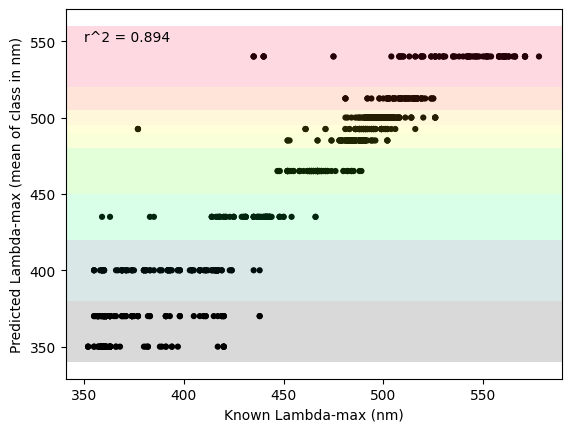

In [ ]:
file = "wds_classifier_test_results_t2.csv"
outfile = "100_iterations_plot"
#https://academo.org/demos/wavelength-to-colour-relationship/

#Read data
table = pd.read_csv(file, delimiter = ',')

#Duplicate predicted class next to change to actual lmax 
table['Predicted_lmax'] = table.loc[:, 'Predicted_Class']
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        table['Predicted_lmax'] = table['Predicted_lmax'].replace(i,mean([class_list[i],class_list[i+1]]))
        i+=1
    else: 
        pass


colorby='Score'

#2d
sns.scatterplot(x='Lambda_Max', y='Predicted_lmax', data=table, edgecolor = 'none', color = 'black', s = 20)
plt.xlabel('Known Lambda-max (nm)')
plt.ylabel('Predicted Lambda-max (mean of class in nm)')

i = 0
alpha = 0.05
for wavelengths in class_list:
    if i+1 < len(hex_list):
        print(hex_list[i])
        plt.axhspan(class_list[i],class_list[i+1], facecolor=hex_list[i], alpha=0.15)
        i+=1
    else: 
        pass
    #place colored bands behind plot

m = plt.annotate("r^2 = {:.3f}".format(r2_score(table['Lambda_Max'],table['Predicted_lmax'])), (350, 550))
print(m)
#If no file name show on screen otherwise save pdf
if outfile == '' :
    plt.show()
else:
    fileout = outfile + '.pdf'
    plt.savefig(fileout)


# <font color=red>Step 6: Earth Movers Distance (EMD) of Test Results -</font>
The following code blocks take results from the 100 iterations test and calculates the EMD between the observed and idealized results. 

In [ ]:
from scipy.stats import wasserstein_distance


Input for EMD calculator is the list of class boundaries and the results csv from the 100 iterations test...
Use this metric to calc a p-value by doing various data perturbations...
OR
Use to compare the performance of different models!

In [ ]:
class_list = 340,360,380,420,450,480,490,495,505,520,560
class_means = []
i = 0
for colors in class_list:
#Convert class values to median lambda max value of that class in new column
    if i+1 != len(class_list):
        mean_lambda = mean([class_list[i],class_list[i+1]])
        class_means.append(mean_lambda)
        i+=1
    else: 
        pass

#print(class_means)

class_diffs = []
i = 0
for means in class_means:
    if i+1 != len(class_means):
        #if i == 0:
            #class_diffs.append(0)
        diff_lambda = float(class_means[i+1] - class_means[i])
        class_diffs.append(diff_lambda)
        i+=1
    else: 
        pass

#These will be the weights between classes, and will be additive as the prediction gets further from the ground-truth classification.
print(class_diffs)
#Will need to make it so weight assignment has a 'row_count' corresponding to the class 'y' value of the ordered pair.
class_count = range(len(class_means))
#make a set of all possible ordered pair combinations...
#(0,0),(0,1),(0,2)....
ordered_pairs = []
#m will be our'known_class'
for m in class_count:
    i = 0
    while i <= len(class_count)-1:
        ordered_pairs.append([i,m])
        i+=1
#print(ordered_pairs)
iter_res = open("wds_classifier_test_results_t2.csv", "r",)
results_csv = csv.reader(iter_res, delimiter=",")
data_columns = ["Pred_Known","Count","Weight","Score","True_Num"]
results_df = pd.DataFrame(columns=data_columns)
results_df.Pred_Known = ordered_pairs
results_df.Count = 0 
results_df.Score = 0
results_df.Weight = 0
results_df.True_Num = 0
results_df.set_index("Pred_Known")
#print(results_df)
x = 0
for entry in results_csv:
    if x == 0:
        x+=1
    else:
        pair = [int(entry[2]),int(entry[1])]
        i = 0
        for plot in results_df.Pred_Known:
            if plot[0] == pair[0] and plot[1] == pair[1]:
                results_df.Count[i]+= 1
                results_df.Score[i] += float(entry[4])
                m = 0
                for s in results_df.Pred_Known:
                    if s[1] == pair[1] and s[0] == s[1]: 
                        results_df.True_Num[m] += 1 
                    m+=1
            i+=1
    

x = 0
for score in results_df.Score:
    if score == 0:
        results_df.Score[x] = 0.000
    else:
        score = score / results_df.Count[x]
        results_df.Score[x] = score

    x+=1
#print(results_df)

x = 0
for plot in results_df.Pred_Known:
    #iterate through and assign weights to each ordered pair...
        #weight = mean confidence score x sum of the differences between means of class range that serpate the prediction from ground truth.
    if plot[0] > plot[1]:
        i = plot[1]
        while i < plot[0]:
            results_df.Weight[x] += class_diffs[i] * results_df.Score[x]
            i+=1
    elif plot[0] < plot[1]:
        i = plot[0]
        while i < plot[1]:
            results_df.Weight[x] +=  class_diffs[i] * results_df.Score[x] 
            i+=1          
    else:
        pass
    x+=1
print(results_df)

whole_matrix = wasserstein_distance(results_df.Count.to_list(),results_df.True_Num.to_list(),results_df.Weight.to_list(),results_df.Weight.to_list())
emd = str(whole_matrix)
print(emd)

results_df.to_csv(path_or_buf="100_iter_matrix.csv",index = False,mode="w")


[20.0, 30.0, 35.0, 30.0, 20.0, 7.5, 7.5, 12.5, 27.5]


C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Count[i]+= 1
C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Score[i] += float(entry[4])
C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.True_Num[m] += 1


   Pred_Known  Count     Weight     Score  True_Num
0      [0, 0]     45   0.000000  0.843980        73
1      [1, 0]     17  12.648118  0.632406         0
2      [2, 0]     10  25.082000  0.501640         0
3      [3, 0]      1  53.422500  0.628500         0
4      [4, 0]      0   0.000000  0.000000         0
..        ...    ...        ...       ...       ...
95     [5, 9]      0   0.000000  0.000000         0
96     [6, 9]      0   0.000000  0.000000         0
97     [7, 9]      5  29.624800  0.740620         0
98     [8, 9]      6  23.390125  0.850550         0
99     [9, 9]     77   0.000000  0.910905        88

[100 rows x 5 columns]
7.778649257925016


C:\Users\safra\AppData\Local\Temp\ipykernel_50360\3047994040.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df.Weight[x] += class_diffs[i] * results_df.Score[x]
